In [2]:
"""Use Nick's PPO trained policy to perform inference on whether there is a pedestrian or not"""

import argparse
from datetime import datetime
import gym
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import PyQt5

import ray
try:
    from ray.rllib.agents.agent import get_agent_class
except ImportError:
    from ray.rllib.agents.registry import get_agent_class
from ray.tune.registry import register_env

# from flow.algorithms.maddpg.maddpg import DEFAULT_CONFIG as MADDPG_DEFAULT_CONFIG, MADDPGTrainer


from flow.core.util import emission_to_csv
from flow.utils.registry import make_create_env
from flow.utils.rllib import get_flow_params
from flow.utils.rllib import get_rllib_config
from flow.utils.rllib import get_rllib_pkl

from examples.rllib.multiagent_exps.test_predictor.pedestrian_policy_1 import create_env, create_agent
from examples.rllib.multiagent_exps.bayesian_0_env import make_flow_params as bayesian_0_flow_params

EXAMPLE_USAGE = """
example usage:
    python ./visualizer_rllib.py /ray_results/experiment_dir/result_dir 1
Here the arguments are:
1 - the path to the simulation results
2 - the number of the checkpoint
"""

In [3]:
import tensorflow as tf
import ray
import gym

In [4]:
ray.__version__

'0.8.0'

Policy takes in an observation of length 22 (10 + max_num_objects * 3)

observation[4:10] = ped_param

I want the set to posterior probabilities: $$Pr(\text{ped_in_grid_i} | action), \forall i = 1, \ldots, 6$$

$Pr(\text{ped_in_grid_i} | \text{action}) = \frac{Pr(\text{action} | \text{ped_in_i}) Pr(\text{ped_in_i})}{Pr(\text{action})}$

$\Pr(action) = \sum_{i=1}^6 \Pr(action | ped\text{_}in\text{_}i) \Pr(ped\text{_}in\text{_}i)$


Compute Pr(action | ped_in_i) by taking

1. actual state e.g. s = [a, b, c, d, [0], e, _, _, _], where I only care about the ith grid (suppose there is no ped in the ith grid)

2. actual state with flipped pedestrian at grid i, i.e
s_flipped = [a, b, c, d, [1], e, _, _, _]

Input these two into the policy to get PDFs:

If $s[i] == 0,$ ped_PDF = $\pi(s\text{_}flipped)$ and no_ped_PDF = $\pi(s)$. Pr(action | ped_in_i) = $\frac{ped\text{_}PDF}{ped\text{_}PDF + ped\text{_}no\text{_}PDF}$

If $s[i] == 1,$ ped_PDF = $\pi(s)$ and no_ped_PDF = $\pi(s\text{_}flipped)$. Pr(action | ped_in_i) = $\frac{ped\text{_}PDF}{ped\text{_}PDF + ped\text{_}no\text{_}PDF}$

and do the usual normalization thing to get Pr(action | ped_in_i)

# The Math

Now, suppose we have access to some PDF $f(a| o_1, o_2, \ldots, o_6)$, where $o_i$ for $i = 1, \ldots, 6$ are indicator variables for whether a pedestrian is or isn't on grid $i$ (as defined in the figure $<insert figure>)$.

Our goal: $p(o_i = b_i| a), \forall i = 1, \ldots, 6$, $b_i \in \{0, 1\}$. We get these 'single' conditional probabilities we want by marginalizing:

\begin{equation}
    p(o_1 = b_1 | a) = \sum_{b_2, \ldots, b_6} p(o_1 = b_1, \ldots, o_6 = b_6 |a )
\end{equation}

Thus, to get these 'single' conditional probabilities, we need to calculate these joint conditional probabilities: $p(o_1 = b_1, \ldots, o_6 = b_6 |a), \forall b_i \in \{0, 1\}, i \in 1, \ldots, 6$. Via Bayes' rule again:

\begin{equation}
    p(o_1 = b_1, \ldots, o_6 = b_6 |a ) = \frac{p(a | o_1 = b_1, \ldots, o_6 = b_6) p(o_1, \ldots, o_6)}{p(a)}    
\end{equation}

Since we only have access to the PDF $f(a | o_1 = b_1, \ldots, o_6 = b_6)$, we'd end up with the PDF $f(o_1 = b_1, \ldots, o_6 = b_6 |a )$ from the equation above. That is, we get:

\begin{equation}
    f(o_1 = b_1, \ldots, o_6 = b_6 |a ) = \frac{f(a | o_1 = b_1, \ldots, o_6 = b_6) p(o_1, \ldots, o_6)}{p(a)}    
\end{equation}

To get the probability $p(o_1 = b_1, \ldots, o_6 = b_6 |a)$, we normalize:

\begin{equation}
p(o_1 = b_1, \ldots, o_6 = b_6 |a) = \frac{f(o_1 = b_1, \ldots, o_6 = b_6 |a)}{c}    
\end{equation}

where $c = \sum_{b_1, \ldots, b_6} f(o_1 = b_1, \ldots, o_6 = b_6 |a)$

Note that we can drop the denominator $p(a)$ in equation 6 since we're normalizing these PDFs into probabilities. Thus, we can just let

\begin{equation}
f(o_1 = b_1, \ldots, o_6 = b_6 |a) = f(a | o_1 = b_1, \ldots, o_6 = b_6) p(o_1 = b_1, \ldots, o_b = b_6) 
\end{equation}

Notice that we'll need $2^6$ of these conditional densities / probabilities.
Explicitly, we need $2^6$ of $f(a | \cap_i o_i = b_i), f(\cap_i o_i = b_i | a), p(\cap_i o_i = b_i | a)$.  

In [5]:
def run_env(env, agent, config, flow_params):
    """Run the simulation and control the rl car using the trained policy. 
    
    observation[4:10] = ped_param
    
    The six binary grids are at indices 4 to 9 inclusive
    """
    # set up relevant policy and env
    if config.get('multiagent', {}).get('policies', None):
        multiagent = True
        rets = {}
        # map the agent id to its policy
        policy_map_fn = config['multiagent']['policy_mapping_fn']
        
#         policy_map_fn = config['multiagent']['policy_mapping_fn'].func
        for key in config['multiagent']['policies'].keys():
            rets[key] = []
    else:
        multiagent = False
        rets = []

    if config['model']['use_lstm']:
        use_lstm = True
        if multiagent:
            state_init = {}
            # map the agent id to its policy
#             policy_map_fn = config['multiagent']['policy_mapping_fn'].func

            policy_map_fn = config['multiagent']['policy_mapping_fn']
            size = config['model']['lstm_cell_size']
            for key in config['multiagent']['policies'].keys():
                state_init[key] = [np.zeros(size, np.float32),
                                   np.zeros(size, np.float32)]
        else:
            state_init = [
                np.zeros(config['model']['lstm_cell_size'], np.float32),
                np.zeros(config['model']['lstm_cell_size'], np.float32)
            ]
    else:
        use_lstm = False

    env.restart_simulation(
        sim_params=flow_params['sim'], render=flow_params['sim'].render)

    
    # Define variables to collect probability data. Each variable is dict
    # 2^6 keys (or, 2^5 values for p(o_i = b_i)) and values will be a list of numbers
    # TODO(KL) HARD CODED is_ped_visible is the 5th item in the state vector

    ped_idx_lst = [4, 5, 6, 7, 8, 9]
    ped_front = ped_idx_lst[0]
    ped_back = ped_idx_lst[-1]
    
    binary_observations = True
    
    
    # dict for f(a | o_i = b_i), where the key is bitstring s e.g.s = "010011", 
    # where s[i] corresponds to the value of b_i. cond_pdf_a_on_joint_ped["010011"] = list()
    
    # 1
    # IF binary_observations == True:
    cond_pdf_action_on_joint_ped_dct = make_dct_of_lsts(num_digits=len(ped_idx_lst), vals_per_dig=2)
    
    # 2
    # updated Pr(o_1 = b_1, ..., o_6 = b_6) for i = 1, ..., 6 and b_i = 0, 1
    updated_joint_prior_prob_ped_dct = initial_prior_probs(num_digits=6, vals_per_dig=2)
    # fixed Pr(o_1 = b_1, ..., o_6 = b_6) for i = 1, ..., 6 and b_i = 0, 1
    fixed_joint_prior_prob_ped_dct = initial_prior_probs(num_digits=6, vals_per_dig=2)
    
    # 3
    # updated joint cond_densities lst f(o_1 = b_1, ..., o_6 = b_6 | a)
    joint_cond_densities_updated_priors_dct = make_dct_of_lsts(num_digits=6, vals_per_dig=2)
    # fixed joint cond_densities lst f(o_1 = b_1, ..., o_6 = b_6 | a)
    joint_cond_densities_fixed_priors_dct = make_dct_of_lsts(num_digits=6, vals_per_dig=2)

    # 4
    # updated joint cond_probs lst p(o_1 = b_1, ..., o_6 = b_6 | a)
    joint_cond_probs_updated_priors_dct = make_dct_of_lsts(num_digits=6, vals_per_dig=2)
    # fixed joint cond_probs lst p(o_1 = b_1, ..., o_6 = b_6 | a)
    joint_cond_probs_fixed_priors_dct = make_dct_of_lsts(num_digits=6, vals_per_dig=2)
    
    # 5
    # updated single cond_probs lst p(o_i = b_i | a)
    single_cond_probs_updated_priors_lst = make_single_cond_prob_dct_of_lsts(num_variables=6, vals_per_var=2)
    # fixed single cond_probs lst p(o_i = b_i | a)
    single_cond_probs_fixed_priors_lst = make_single_cond_prob_dct_of_lsts(num_variables=6, vals_per_var=2)
    
    # 6
    # this will be the only variable that's a dict of lists
    visible_pedestrian_dct = {i : [] for i in range(1,7)}

    # each element in this list corresponds to a key 
    len_6_bitstring_lst = make_permutations(num_digits=6, vals_per_dig=2)
    for i in range(args.num_rollouts):
        state = env.reset()
        # divide by 5 to get "time" in the simulation
        for _ in range(1000):
            vehicles = env.unwrapped.k.vehicle
            pedestrian = env.unwrapped.k.pedestrian
            if multiagent:
                
                action, logits = {}, {}

                for agent_id in state.keys():
                    if use_lstm:
                        action[agent_id], state_init[agent_id], logits = \
                            agent.compute_action(state[agent_id], state=state_init[agent_id], policy_id=policy_map_fn(agent_id))
                    else:
                        # s_all is the state that the agent observes
                        s_all = state[agent_id]
                        # get ped visibility state array of length 6 from the rl car's POV
                        s_ped = s_all[ped_idx_lst]
                        
                        # update the visible_pedestrian dict
                        for idx, val in enumerate(s_ped, 1):
                            visible_pedestrian_dct[idx] = visible_pedestrian_dct[idx] + [val]
                            
                        # compute the actual action taken by the rl car
                        action[agent_id], _, logit_actual = agent.compute_action(state[agent_id], policy_id=policy_map_fn(agent_id), full_fetch=True)    
                        action_ = action[agent_id][0]
                        
                        # store variable for the sum of densities conditioned on the actual action
                        cond_density_sum_updated = 0
                        cond_density_sum_fixed = 0

                        # compute joint conditional densities for all possible permutations of ped visibility (ignore which permutation corresponds to the actual permutation for now)
                        for obs_comb in len_6_bitstring_lst:
                            # s_all_modified is the hypothetical state that an agent observes
                            s_all_modified = np.copy(s_all)
                            s_all_modified[ped_front : ped_back + 1] = list(obs_comb)
                            _, _, logit = agent.compute_action(s_all_modified, policy_id=policy_map_fn(agent_id), full_fetch=True)
                            # where in the docs did we figure out the logits were ln of sigma??
                            mu, ln_sigma = logit['behaviour_logits']
                            sigma = np.exp(ln_sigma)
                            
                            # 1
                            # compute the conditional a_given_obs pdfs, i.e. f(a | o_1 = b_1, ..., o_6 = b_6)
                            cond_a_given_joint_o_pdf = accel_pdf(mu, sigma, action_)
                            # append new result to lists
                            cond_pdf_action_on_joint_ped_dct[obs_comb] = cond_pdf_action_on_joint_ped_dct[obs_comb] + [cond_a_given_joint_o_pdf]
                            # 2
                            # Get the updated and fixed priors
                            updated_prior = updated_joint_prior_prob_ped_dct[obs_comb][-1]
                            fixed_prior = 1 / 2**6
#                             print(f'updated_prior is {updated_prior}, fixed prior is {fixed_prior}')
                            # 3
                            # compute the joint conditional obs_given_a pdfs, i.e. f(o_1 = b_1, ..., o_6 = b_6 | a)
                            cond_joint_o_given_a_pdf_updated = cond_a_given_joint_o_pdf * updated_prior
                            cond_joint_o_given_a_pdf_fixed = cond_a_given_joint_o_pdf * fixed_prior
                            # append new result to lists
                            joint_cond_densities_updated_priors_dct[obs_comb] = joint_cond_densities_updated_priors_dct[obs_comb] + [cond_joint_o_given_a_pdf_updated]
                            joint_cond_densities_fixed_priors_dct[obs_comb] = joint_cond_densities_fixed_priors_dct[obs_comb] + [cond_joint_o_given_a_pdf_fixed]

                            cond_density_sum_updated += cond_joint_o_given_a_pdf_updated
                            cond_density_sum_fixed += cond_joint_o_given_a_pdf_fixed
                            
                        # 4
                        # compute Pr(o_1 = b_1, ... o_6 = b_6 | a)
                        for obs_comb_ in len_6_bitstring_lst:
                            cond_joint_o_given_a_prob_updated = joint_cond_densities_updated_priors_dct[obs_comb_][-1] / cond_density_sum_updated
                            cond_joint_o_given_a_prob_fixed = joint_cond_densities_fixed_priors_dct[obs_comb_][-1] / cond_density_sum_fixed
                            # append to lists
                            joint_cond_probs_updated_priors_dct[obs_comb_] = joint_cond_probs_updated_priors_dct[obs_comb_] + [cond_joint_o_given_a_prob_updated]
                            joint_cond_probs_fixed_priors_dct[obs_comb_] = joint_cond_probs_fixed_priors_dct[obs_comb_] + [cond_joint_o_given_a_prob_fixed]
                        
                            # 2
                            # Update the updated and fixed priors lists
                            updated_joint_prior_prob_ped_dct[obs_comb_] = updated_joint_prior_prob_ped_dct[obs_comb_] + [cond_joint_o_given_a_prob_updated]
                            fixed_joint_prior_prob_ped_dct[obs_comb_] = fixed_joint_prior_prob_ped_dct[obs_comb_] + [cond_joint_o_given_a_prob_fixed]
                        
                        # 5
                        # compute Pr(o_i = b_i | a) for all i = 1, ..., 6
                        for grid_idx in range(1, 7):
                            for val in range(0, 2):
                                # compute the marginalization (4) - need to get the relevant ped observation combinations
                                single_cond_o_given_a_prob_updated = 0
                                single_cond_o_given_a_prob_fixed = 0

                                for key in ped_combos_for_single_cond_prob(grid_idx, val):
                                    single_cond_o_given_a_prob_updated += joint_cond_probs_updated_priors_dct[key][-1]
                                    single_cond_o_given_a_prob_fixed += joint_cond_probs_fixed_priors_dct[key][-1]
                                
                                single_cond_prob_str = single_cond_prob_to_str(grid_idx, val)

                                single_cond_probs_updated_priors_lst[single_cond_prob_str] = single_cond_probs_updated_priors_lst[single_cond_prob_str] + [single_cond_o_given_a_prob_updated]
                                single_cond_probs_fixed_priors_lst[single_cond_prob_str] = single_cond_probs_fixed_priors_lst[single_cond_prob_str] + [single_cond_o_given_a_prob_fixed]
                                
            else:
                action = agent.compute_action(state)
            state, reward, done, _ = env.step(action)

            if multiagent and done['__all__']:
                print(_,1)
                break
            if not multiagent and done:
                print(_,1)

                break    
            state, reward, done, _ = env.step(action)   

        visible_ped_lsts = [visible_pedestrian_dct[i] for i in range(1, 7)]
        legends = [f'ped in grid {i}' for i in range(1, 7)]
        joint_cond_probs_updated_priors_dct['000000'], joint_cond_probs_updated_priors_dct['000001']

        for grid_idx in range(1, 7):
            val = 1
#             for val in range(0, 2):
            single_cond_prob_str = single_cond_prob_to_str(grid_idx, val)
            a_ = single_cond_probs_updated_priors_lst[single_cond_prob_str]
            b_ = single_cond_probs_fixed_priors_lst[single_cond_prob_str]

            plot_2_lines(a_, b_, [f'Pr(ped in grid {grid_idx} = {val}) using updated priors', f'Pr(ped in grid {grid_idx} = {val}) using fixed priors'])

        fig = plt.figure(figsize=(15, 15))

        y1 = visible_pedestrian_dct[1]
        y2 = visible_pedestrian_dct[2]
        y3 = visible_pedestrian_dct[3]
        y4 = visible_pedestrian_dct[4]
        y5 = visible_pedestrian_dct[5]
        y6 = visible_pedestrian_dct[6]

        vis_ped_1 = plt.subplot(3, 3, 1)
        plt.plot(y1, 'o-')
        vis_ped_1.set_title('Pedestrian in grid 1')
        vis_ped_1.set_xlabel('time (s)')
        vis_ped_1.set_ylabel('in grid 1?')

        vis_ped_2 = plt.subplot(3, 3, 2)
        vis_ped_2.plot(y2, '.-')
        vis_ped_2.set_title('Pedestrian in grid 2')

        vis_ped_2.set_xlabel('time (s)')
        vis_ped_2.set_ylabel('in grid 2?')
        
        vis_ped_3 = plt.subplot(3, 3, 3)
        vis_ped_3.plot(y2, '.-')
        vis_ped_3.set_title('Pedestrian in grid 3')

        vis_ped_3.set_xlabel('time (s)')
        vis_ped_3.set_ylabel('in grid 3?')
        
        vis_ped_4 = plt.subplot(3, 3, 4)
        vis_ped_4.plot(y2, '.-')
        vis_ped_4.set_title('Pedestrian in grid 4')

        vis_ped_4.set_xlabel('time (s)')
        vis_ped_4.set_ylabel('in grid 4?')
        
        vis_ped_5 = plt.subplot(3, 3, 5)
        vis_ped_5.plot(y2, '.-')
        vis_ped_5.set_title('Pedestrian in grid 5')

        vis_ped_5.set_xlabel('time (s)')
        vis_ped_5.set_ylabel('in grid 5?')
        
        vis_ped_6 = plt.subplot(3, 3, 6)
        vis_ped_6.plot(y2, '.-')
        vis_ped_6.set_title('Pedestrian in grid 6')

        vis_ped_6.set_xlabel('time (s)')
        vis_ped_6.set_ylabel('in grid 6?')




In [9]:
print(make_permutations(num_digits=6, vals_per_dig=2))
single_cond_prob_to_str(1, 0)
len(ped_combos_for_single_cond_prob(1, 0))

['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001011', '001100', '001101', '001110', '001111', '010000', '010001', '010010', '010011', '010100', '010101', '010110', '010111', '011000', '011001', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100010', '100011', '100100', '100101', '100110', '100111', '101000', '101001', '101010', '101011', '101100', '101101', '101110', '101111', '110000', '110001', '110010', '110011', '110100', '110101', '110110', '110111', '111000', '111001', '111010', '111011', '111100', '111101', '111110', '111111']


32

In [10]:
def single_cond_prob_to_str(grid_idx, val, num_indices = 6):
    """Generate the string representing the probability:
    
    Pr(o_i = val)
    
    ex:
    For Pr(o_2 = 1), we'd have the string '21'
    NB we're 1-indexing here
    """
    assert grid_idx >= 1 and grid_idx <= num_indices
    return str(grid_idx) + str(val)

# better name for this? 
def ped_combos_for_single_cond_prob(grid_idx, val, output_len=6):
    """Helper function for computing a 'single' conditional probability e.g. p(o_3 = 1 | action)
    Returns a list of pedestrian combinations to sum over to get the single conditional probability.
    
    Params
    ------
    grid_idx: int from 1 to 6 representing the grid cell we're considering
    val: 0 or 1: 0 means no ped in the grid; 1 means ped in the grid
    
    3:0 means we want p(o_3 = 0 | a)
    Therefore, we can get the list of all possible length 5 bitstrings, and stitch '0' in the correct place.
    
    
    Returns
    -------
    list of bit strings of length 6
    """
    
    assert grid_idx >= 1 and grid_idx <= output_len
    res = []
    res_lst = make_permutations(output_len - 1, 2)
    
    for perm in res_lst:
        res.append(str(perm[:grid_idx - 1:] + str(val) + perm[grid_idx - 1:]))
        
    return res

def initial_prior_probs(num_digits=6, vals_per_dig=2):
    """Returns a dict with values of all permutations of bitstrings of length num_digits. 
    Each digit can take a value from 0 to (vals_per_dig - 1)"""
    uniform_prob = 1 / (vals_per_dig ** num_digits)
    res = make_dct_of_lsts(num_digits, vals_per_dig)
    for key in res.keys():
        res[key] = res[key] + [uniform_prob]
    return res

def make_dct_of_lsts(num_digits=6, vals_per_dig=2):
    """Return a dict with keys of bitstrings and values as empty lists. 
    Hardcoded for binary vals per var."""
    res = {}
    lst_of_bitstrings = make_permutations(num_digits, vals_per_dig)
        
    return {str_ : [] for str_ in lst_of_bitstrings}

def make_permutations(num_digits, vals_per_dig=2):
    """Make all permutations for a bit string of length num_digits
    and vals_per_dig values per digit. Hardcoded for work for binary vals per var"""
    if num_digits == 1:
        return [str(i) for i in range(vals_per_dig)]
    else:
        small_perms = make_permutations(num_digits - 1, vals_per_dig)
        # hardcoded for work for binary vals per var
        return ['0' + bit_str for bit_str in small_perms] + ['1' + bit_str for bit_str in small_perms]
    
def make_single_cond_prob_dct_of_lsts(num_variables=6, vals_per_var=2):
    """@Params
    num_variables = number of states that we care about
    
    @Returns
    dict of lists. Keys have the format: 'o_{i}={val}', where val is either '0' or '1'
    """
    res = {}
    for i in range(1, num_variables + 1):
        for val in range(vals_per_var):
            res[f'{i}{val}'] = []
    return res

## Helper function testing suite

Define indicator RVs $G_i$, where $G_i = 1$ if there's a pedestrian in grid cell $i$ and $0$ if not.

Want $Pr(G_i = 1 | action) = \frac{Pr(action | G_i = 1) Pr(G_i = 1)}{Pr(G_i = 1)}$

Consider grid 1:
$\begin{equation} \label{eq1}
\begin{split}
Pr(action | G_1 = 1) & = \frac{Pr(action, G_1 = 1)}{Pr(G_1 = 1)} \\
 & = \frac{\sum_{g2 \in \{0, 1\}} \sum_{g3 \in \{0, 1\}} \sum_{g4 \in \{0, 1\}} \sum_{g5 \in \{0, 1\}} \sum_{g6 \in \{0, 1\}} Pr(action, G_1 = 1, G_2 = g2, G_3 = g3, G_4 = g4, G_5 = g5, G_6 = g6)}{Pr(G_1 = 1)} \\
 & = \frac{\sum_{g2 \in \{0, 1\}} \sum_{g3 \in \{0, 1\}} \sum_{g4 \in \{0, 1\}} \sum_{g5 \in \{0, 1\}} \sum_{g6 \in \{0, 1\}} Pr(action | G_1 = 1, G_2 = g2, G_3 = g3, G_4 = g4, G_5 = g5, G_6 = g6) Pr(G_1 = 1, G_2 = g2, G_3 = g3, G_4 = g4, G_5 = g5, G_6 = g6))}{Pr(G_1 = 1)}
\end{split}
\end{equation}$

The policy doesn't actually output a probability; the policy outputs a probability density.
i.e. instead of outputting $Pr(action | G_1 = 1, G_2 = g2, G_3 = g3, G_4 = g4, G_5 = g5, G_6 = g6)$, 
the policy outputs $f(action | G_1 = 1, G_2 = g2, G_3 = g3, G_4 = g4, G_5 = g5, G_6 = g6)$

Perhaps after some handwaving and assumptions about $Pr(G_i = 0) = 0.5$, I could say, I have $f(action | G_1 = 1) \sim \sum \sum \sum \ldots \ldots = k_1$. Note, I don't have equality here. Under the assumption of $Pr(G_i = 0) = 0.5$, the numerator joint probability / density term (assuming independence) is $0.5^6$.

How do I convert these $k_i$'s into probabilities?

Is it feasible to normalize just the 6 $f(action | G_i = 1)$ values, i.e assert

$Pr(action | G_1 = 1) = \frac{f(action | G_1 = 1)}{\sum_{i=1}^6 f(action | G_i = 1)}$?

I don't think this normalization is accurate. It seems more accurate to do:

$Pr(action | G_1 = 1) = \frac{f(action | G_1 = 1)}{f(action | G_1 = 1) + f(action | G_1 = 0)}$?

My doubts are: 

1. the conversion from pdfs to probabilities - is this how we normalize pdfs to get probabilities?




In [11]:
def pr_ped_given_action(action, mu_ped, s_ped, mu_no_ped, s_no_ped, prior, fixed_prior=True):
    """
    @Params
    mu_ped, s_ped: mean, sd pair from the policy receiving an input state where there is a visible pedestrian 
    mu_no_ped, s_no_ped: mean, sd pair from the policy receiving an input state where there is no visible pedestrian 

    action: the vehicle's acceleration as dictated by the policy
    prior: Pr(ped)
    fixed_prior: Boolean telling us whether to 'update' the prior Pr(ped) using Pr(ped | action) or not

    @Returns
    
    probs, a dict containing:
    1. Pr(action | ped)
    2. Pr(action | no_ped)
    3. Pr(ped | action)
    4. Pr(no_ped | action)
    5. Pr(ped) for the next computation of Pr(ped|action)
    
    3, 4, 5 are calculated subject to the fixed_prior parameter
    """
    probs = {}
    
    # Compute 1, 2: Pr(action | ped), Pr(action | no_ped)
    unnormed_pr_action_given_ped = accel_pdf(mu_ped, s_ped, action)
    unnormed_pr_action_given_no_ped = accel_pdf(mu_no_ped, s_no_ped, action)
    
    pr_a_given_ped = unnormed_pr_action_given_ped / (unnormed_pr_action_given_ped + unnormed_pr_action_given_no_ped)
    pr_a_given_no_ped = 1 - pr_a_given_ped
    
    probs["pr_a_given_ped"] = pr_a_given_ped
    probs["pr_a_given_no_ped"] = pr_a_given_no_ped
    
    # Compute 3, 4: Pr(ped | action), Pr(no_ped | action)
    # Apply Bayes' rule
    pr_ped_given_action = (pr_a_given_ped * prior) / ((pr_a_given_ped * prior)  + (pr_a_given_no_ped * (1 - prior)))
    pr_no_ped_given_action = (pr_a_given_no_ped * (1 - prior)) / ((pr_a_given_ped * prior)  + (pr_a_given_no_ped * (1 - prior)))
    probs["pr_ped_given_action"] = pr_ped_given_action
    probs["pr_no_ped_given_action"] = pr_no_ped_given_action
                    
    if fixed_prior:
        probs["prior"] = prior
    else:
        probs["prior"] = probs["pr_ped_given_action"]
    return probs
    

def accel_pdf(mu, sigma, actual):
    """Return pdf evaluated at actual acceleration"""
    coeff = 1 / np.sqrt(2 * np.pi * (sigma**2))
    exp = -0.5 * ((actual - mu) / sigma)**2
    return coeff * np.exp(exp)

def run_transfer(args):
    # run transfer on the bayesian 1 env first
    bayesian_0_params = bayesian_0_flow_params(args, pedestrians=True, render=True)
#     import ipdb; ipdb.set_trace()
    env, env_name = create_env(args, bayesian_0_params)
    agent, config = create_agent(args, flow_params=bayesian_0_params)
    run_env(env, agent, config, bayesian_0_params)

def plot_2_lines(y1, y2, legend, viewable_ped=False):
    x = np.arange(len(y1))
    plt.plot(x, y1)
    plt.plot(x, y2)
    if viewable_ped:
        plt.plot(x, viewable_ped)
    plt.legend(legend, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
   
    plt.draw()
    plt.pause(0.001)
    
def plot_lines(y_val_lsts, legends):
    assert len(y_val_lsts) == len(legends)
    x = np.arange(len(y_val_lsts[0]))
    for y_vals in y_val_lsts:
        plt.plot(x, y_vals)
    plt.legend(legends, bbox_to_anchor=(0.5, 1.05), loc=3, borderaxespad=0.)
    plt.draw()
    plt.pause(0.001)

In [12]:
def create_parser():
    """Create the parser to capture CLI arguments."""
    parser = argparse.ArgumentParser(
        formatter_class=argparse.RawDescriptionHelpFormatter,
        description='[Flow] Evaluates a reinforcement learning agent '
                    'given a checkpoint.',
        epilog=EXAMPLE_USAGE)

    # required input parameters
    parser.add_argument(
        'result_dir', type=str, help='Directory containing results')
    parser.add_argument('checkpoint_num', type=str, help='Checkpoint number.')

    # optional input parameters
    parser.add_argument(
        '--run',
        type=str,
        help='The algorithm or model to train. This may refer to '
             'the name of a built-on algorithm (e.g. RLLib\'s DQN '
             'or PPO), or a user-defined trainable function or '
             'class registered in the tune registry. '
             'Required for results trained with flow-0.2.0 and before.')
    parser.add_argument(
        '--num_rollouts',
        type=int,
        default=1,
        help='The number of rollouts to visualize.')
    parser.add_argument(
        '--gen_emission',
        action='store_true',
        help='Specifies whether to generate an emission file from the '
             'simulation')
    parser.add_argument(
        '--evaluate',
        action='store_true',
        help='Specifies whether to use the \'evaluate\' reward '
             'for the environment.')
    parser.add_argument(
        '--render_mode',
        type=str,
        default='sumo_gui',
        help='Pick the render mode. Options include sumo_web3d, '
             'rgbd and sumo_gui')
    parser.add_argument(
        '--save_render',
        action='store_true',
        help='Saves a rendered video to a file. NOTE: Overrides render_mode '
             'with pyglet rendering.')
    parser.add_argument(
        '--horizon',
        type=int,
        help='Specifies the horizon.')
    
    parser.add_argument('--grid_search', action='store_true', default=False,
                        help='If true, a grid search is run')
    parser.add_argument('--run_mode', type=str, default='local',
                        help="Experiment run mode (local | cluster)")
    parser.add_argument('--algo', type=str, default='TD3',
                        help="RL method to use (PPO, TD3, MADDPG)")
    parser.add_argument("--pedestrians",
                        help="use pedestrians, sidewalks, and crossings in the simulation",
                        action="store_true")
    
    return parser

2020-04-13 15:26:15,028	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-04-13 15:26:15,029	INFO resource_spec.py:216 -- Starting Ray with 2.64 GiB memory available for workers and up to 1.33 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


NOTE: With render mode sumo_gui, an extra instance of the SUMO GUI will display before the GUI for visualizing the result. Click the green Play arrow to continue.
(2.1)--(1.1) (1.1)--(1.2) 1 1
True
NOTE: With render mode sumo_gui, an extra instance of the SUMO GUI will display before the GUI for visualizing the result. Click the green Play arrow to continue.
(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian1Env-v0
True


2020-04-13 15:26:17,677	INFO trainer.py:371 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-04-13 15:26:17,687	INFO trainer.py:512 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-04-13 15:26:17,688	WARNING ppo.py:168 -- Using the simple minibatch optimizer. This will significantly reduce performance, consider simple_optimizer=False.


(2.1)--(1.1) (1.1)--(1.2) 1 1
Error making env  Cannot re-register id: Bayesian1Env-v0
True


2020-04-13 15:26:19,479	WARNING util.py:45 -- Install gputil for GPU system monitoring.
2020-04-13 15:26:19,506	INFO trainable.py:346 -- Restored from checkpoint: ./PPO_Bayesian1Env-v0_147ad4ee_2020-04-11_11-17-50y_jh0l53/checkpoint_100/checkpoint-100
2020-04-13 15:26:19,506	INFO trainable.py:353 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': 1053765, '_time_total': 15497.171024799347, '_episodes_total': 2685}


 Retrying in 1 seconds
departtime is 5.00


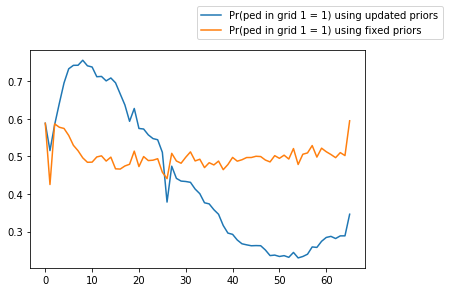

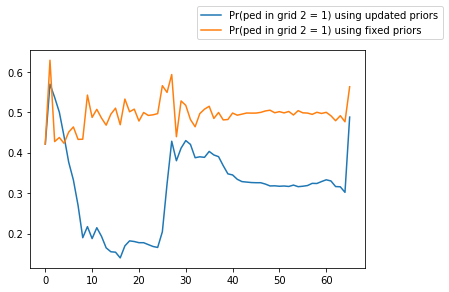

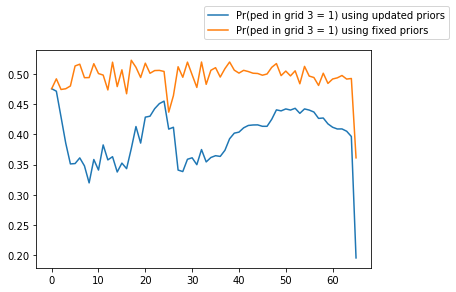

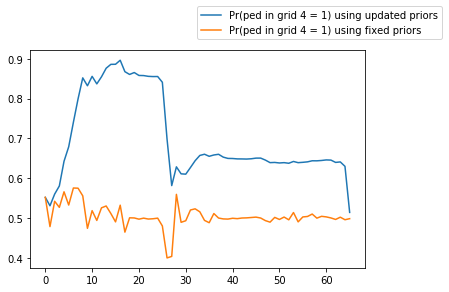

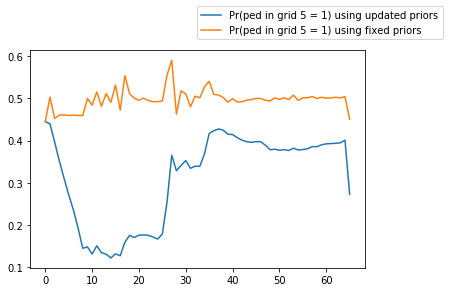

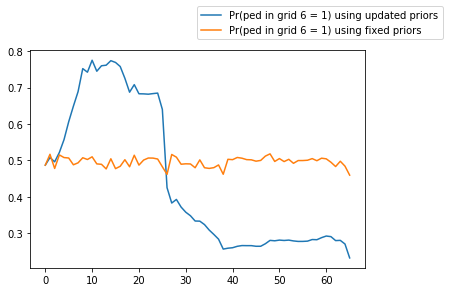

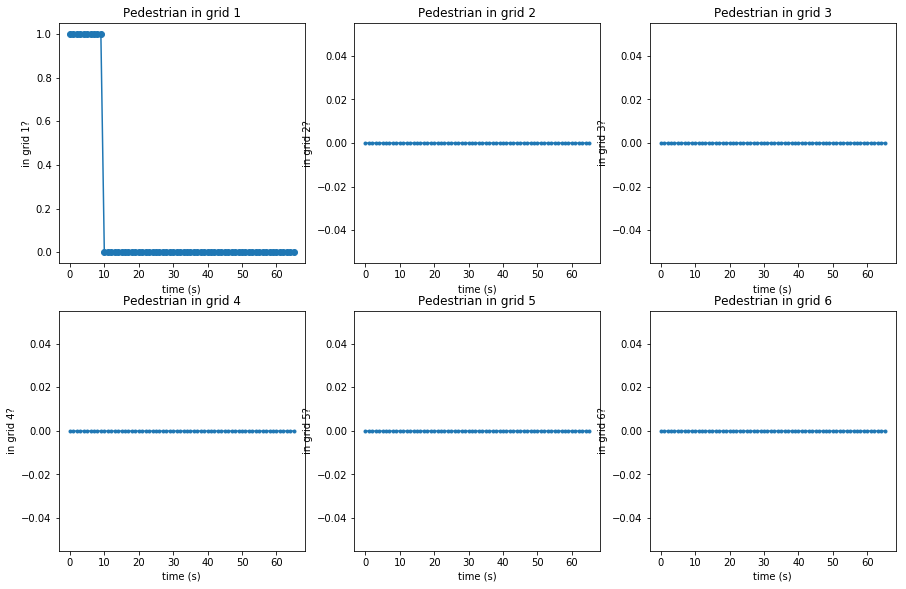

In [13]:
parser = create_parser()
args = parser.parse_args(["./PPO_Bayesian1Env-v0_147ad4ee_2020-04-11_11-17-50y_jh0l53", "100"])
ray.shutdown()
ray.init(num_cpus=1)
run_transfer(args)

In [9]:
import sys
print(sys.path)

['/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7/site-packages/ray/pyarrow_files', '/home/thankyou-always/TODO/research/bayesian_reasoning_traffic/bayesian_inference', '/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7/site-packages', '/home/thankyou-always/TODO/research/bayesian_reasoning_traffic/bayesian_inference', '/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7/site-packages', '/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7/site-packages/ray/pickle5_files', '/home/thankyou-always/TODO/research/bayesian_reasoning_traffic/bayesian_inference', '/home/thankyou-always/anaconda3/envs/flow3.7/lib/python37.zip', '/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7', '/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7/lib-dynload', '', '/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3.7/site-packages', '/home/thankyou-always/TODO/research/bayesian_reasoning_traffic', '/home/thankyou-always/anaconda3/envs/flow3.7/lib/python3

In [20]:
echo $PYTHONPATH

SyntaxError: invalid syntax (<ipython-input-20-4572c3270c61>, line 1)

In [ ]:
b = np.array([11,22, 3, 4, 5, 6, 7])
c = [1, 2, 3]
b[c]

In [ ]:
for idx, val in enumerate(b, 1):
    print(idx, val)

In [8]:
def f(a, b):
    return a + b

In [9]:
f(1, 2, cat=40)

TypeError: f() got an unexpected keyword argument 'cat'

In [39]:
fig = plt.figure()


[1, 2, 3]

Text(0, 0.5, 'Undamped')

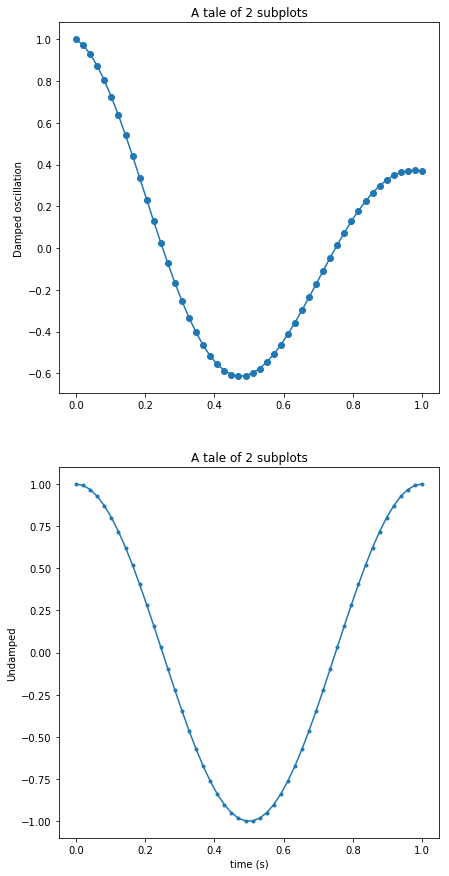

In [57]:
fig = plt.figure(figsize=(15, 15))

x1 = np.linspace(0.0, 1.0)
x2 = np.linspace(0.0, 1.0)

y1 = np.cos(2 * np.pi * x1) * np.exp(-x1)
y2 = np.cos(2 * np.pi * x2)

vax = plt.subplot(2, 2, 1)
plt.plot(x1, y1, 'o-')
vax.set_title('A tale of 2 subplots')
vax.set_ylabel('Damped oscillation')

hax = plt.subplot(2, 2, 3)
hax.plot(x2, y2, '.-')
hax.set_title('A tale of 2 subplots')

hax.set_xlabel('time (s)')
hax.set_ylabel('Undamped')